In [1]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import datetime as dt
import pandas as pd
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey
import numpy as np

In [2]:
# create engine using the `hawaii.sqlite` database file created in database_engineering steps

engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
# declare base using `automap_base()`

Base = automap_base()

In [4]:
# use bse class to reflect the database tables

Base.prepare(engine, reflect=True)

In [5]:
# print classes mapped to the base

Base.classes.keys()

['measurements', 'station', 'stations']

In [6]:
# create inspector and connect it to the engine
inspector = inspect(engine)

# collect names of the tables within the database
inspector.get_table_names()

['measurements', 'station', 'stations']

In [7]:
# use `engine.execute` to select and display the first 10 rows from the table

engine.execute('SELECT * FROM measurements LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (6, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (7, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (8, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (9, 'USC00519397', '2010-01-11', 0.01, 64.0),
 (10, 'USC00519397', '2010-01-12', 0.0, 61.0)]

In [8]:
# reflect the database into ORM class
Stations = Base.classes.stations
Measurements = Base.classes.measurements

In [9]:
# start a session to query the database 
session = Session(engine)

In [10]:
# Precipitation Analysis

In [11]:
# grab most recent date entry in the data table

last_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
print(last_date)

('2017-08-23',)


In [12]:
# grab first date by subtracting from 365

last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [13]:
# query to pull the last year of precipitation data

rain = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

In [14]:
rain_data_df = pd.DataFrame(rain)
rain_data_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,1.22
4,2016-08-24,2.15


In [15]:
# reset the index to the date

rain_data_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


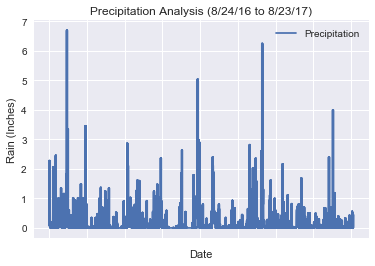

In [30]:
# plot the dataframe

rain_data_df.plot('date', 'prcp')
plt.xlabel("Date",)
plt.ylabel("Rain (Inches)")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.show()

In [33]:
# use pandas to print the summary statistics for the precipitation data

rain_data_df.describe().round(2)

,prcp
count,8060.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


In [35]:
# Station Analysis

In [36]:
# count the number of stations in the measurement table

locations = session.query(Measurements).group_by(Measurements.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [38]:
# find the station with the most temperature observations, then list them all in descending order

busy_stations = session.query(Measurements.station, func.count(Measurements.tobs)).group_by(Measurements.station).\
               order_by(func.count(Measurements.tobs).desc()).all()

busiest = busy_stations[0][0]    
print("The busiest Station was",busiest,"with",busy_stations[0][1],"weather observations.")
print()
print("Here are the Stations (in descending order) with their number of observations:")
for stations, count in busy_stations:
    print("Station",stations,"had",count, "weather observations.")

The busiest Station was USC00519281 with 11088 weather observations.

Here are the Stations (in descending order) with their number of observations:
Station USC00519281 had 11088 weather observations.
Station USC00513117 had 10784 weather observations.
Station USC00519397 had 10740 weather observations.
Station USC00519523 had 10288 weather observations.
Station USC00516128 had 9936 weather observations.
Station USC00514830 had 7748 weather observations.
Station USC00511918 had 7728 weather observations.
Station USC00517948 had 2732 weather observations.
Station USC00518838 had 1368 weather observations.


In [39]:
# query to pull the last year of precipitation data for the busiest station

temperature = session.query(Measurements.station, Measurements.date, Measurements.tobs).\
    filter(Measurements.station == busiest).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

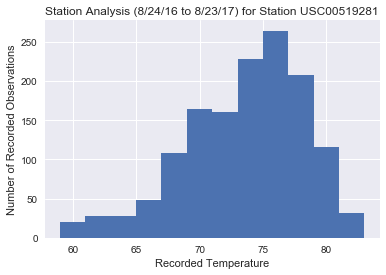

In [40]:
# plot the temperature data in a histogram with 12 bins

temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + busiest)
plt.show()

In [41]:
# Temperature Analysis

In [42]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurements.tobs),
                         func.avg(Measurements.tobs),
                         func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()
    
temp_range = (calc_temps('2016-06-01', '2016-06-08'))
print(temp_range)

[(65.0, 72.73809523809524, 80.0)]


In [43]:
# calculate the min/max/avg from last year that matches my trip date

trip_arrive = dt.date(2018, 6, 1)
trip_leave = dt.date(2018, 6, 8)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)

[(74.0, 77.69565217391305, 81.0)]


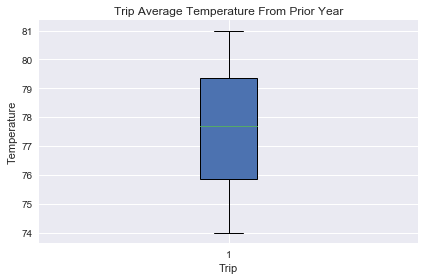

In [44]:
# plotting the data as a boxplot

fig, ax = plt.subplots()
x = range(len(temp_avg_lst_year))
ax.boxplot(temp_avg_lst_year, patch_artist=True)
ax.set_title('Trip Average Temperature From Prior Year')
ax.set_ylabel("Temperature")
ax.set_xlabel("Trip")
fig.tight_layout()
plt.show()

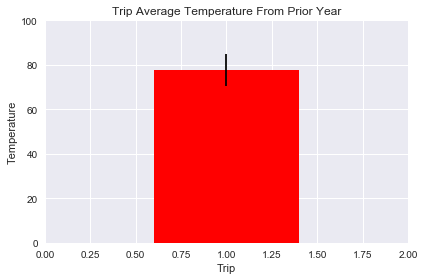

In [49]:
# plot the calculated min/max/avg from last year for the trip dates as a bar chart

last_year = temp_avg_lst_year[0][2]-temp_avg_lst_year[0][0]
avgtemp = temp_avg_lst_year[0][1]
min_temp = temp_avg_lst_year[0][0]
max_temp = temp_avg_lst_year[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'red', yerr=last_year)
ax.set_xlabel("Trip")
ax.set_ylabel("Temperature")
ax.set_title("Trip Average Temperature From Prior Year")      
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.show()